## Scraping Data from Tiktok

In [32]:
import os

from dotenv import load_dotenv
from TikTokApi import TikTokApi

load_dotenv()

True

In [ ]:
ms_token = os.getenv("TIKTOK_MSTOKEN")


async def trending_videos():
    data = []
    async with TikTokApi() as api:
        await api.create_sessions(
            ms_tokens=[ms_token],
            num_sessions=1,
            sleep_after=3,
            browser=os.getenv("TIKTOK_BROWSER", "chromium"),
        )
        async for video in api.trending.videos(count=30):
            print(video)
            print(video.as_dict)
            data.append(video.as_dict)
    return data

In [ ]:
async def get_user():
    data = []
    async with TikTokApi() as api:
        await api.create_sessions(
            ms_tokens=[ms_token],
            num_sessions=1,
            sleep_after=3,
            browser=os.getenv("TIKTOK_BROWSER", "chromium"),
        )
        async for video in api.trending.videos(count=30):
            print(video)
            print(video.as_dict)
            data.append(video.as_dict)
    return data

In [ ]:
data = await trending_videos()

## Save data to file

In [3]:
import json

In [ ]:
with open("example_data.json", "w+") as f:
    f.write(json.dumps(data))

## Data Exploration

In [4]:
import pandas as pd

In [6]:
df = pd.read_json("data.jsonl", lines=True)

In [7]:
df.shape

(57652, 53)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57652 entries, 0 to 57651
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AIGCDescription             56572 non-null  object 
 1   CategoryType                57652 non-null  int64  
 2   author                      56611 non-null  object 
 3   authorStats                 56611 non-null  object 
 4   authorStatsV2               56611 non-null  object 
 5   backendSourceEventTracking  56611 non-null  object 
 6   challenges                  39967 non-null  object 
 7   collected                   56611 non-null  float64
 8   contents                    53396 non-null  object 
 9   createTime                  57652 non-null  int64  
 10  desc                        57652 non-null  object 
 11  digged                      57652 non-null  bool   
 12  diversificationId           50596 non-null  float64
 13  duetDisplay                 566

In [9]:
df["id"].nunique() # is this the video id or the author id? looks like there may be a lot of duplicates

1971

In [24]:
import json
data = []
with open("data.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))

In [ ]:
flat_df = pd.json_normalize(data, max_level=10, errors='ignore')

In [5]:
flat_df.shape

(57652, 218)

In [6]:
flat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57652 entries, 0 to 57651
Columns: 218 entries, AIGCDescription to music.tt2dsp.dsp_platform_selected_by_user
dtypes: bool(6), float64(61), int64(3), object(148)
memory usage: 93.6+ MB


In [7]:
flat_df_dedup = flat_df.drop_duplicates(subset=["id"], keep="first")

In [8]:
flat_df_dedup.shape

(1971, 218)

In [ ]:
flat_df_dedup["author.id"].count()

np.int64(1755)

In [ ]:
with open("columns.txt", "w+") as f:
    f.write(str(list(flat_df_dedup.columns)))

In [9]:
from pydantic import BaseModel, ValidationError

class Video(BaseModel):
    author_id:str
    author_username:str
    verified_status:bool
    author_ban_status:bool=False

    video_id:str
    video_comment_count:int
    video_download_count:int # download == collect?
    video_duration_sec:int
    video_like_count:int
    video_reposts:int
    video_share_count:int
    video_view_count:int

# engagement_rate,like_ratio,share_ratio,comment_ratio


class Creator(BaseModel):
    pass
    

def extract_relevant_fields(record):
    try:
        return Video(
            author_id=record["author.id"],
            author_username=record["author.uniqueId"],
            verified_status=record["author.verified"],

            video_id=record["id"],
            video_comment_count=record["statsV2.commentCount"],
            video_download_count=record["statsV2.collectCount"],
            video_duration_sec=record["video.duration"],
            video_like_count=record["statsV2.diggCount"],
            video_reposts=record["statsV2.repostCount"],
            video_share_count=record["statsV2.shareCount"],
            video_view_count=record["statsV2.playCount"],

        )
    except ValidationError as e:
        return None

In [10]:
cleaned_data = [extract_relevant_fields(row) for index,row in flat_df_dedup.iterrows()]

In [11]:
cleaned_data = list(filter(None, cleaned_data))

In [12]:
len(cleaned_data)

1970

In [13]:
cleaned_df = pd.DataFrame([row.model_dump() for row in cleaned_data])

In [63]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   author_id             1755 non-null   object
 1   author_username       1755 non-null   object
 2   verified_status       1755 non-null   bool  
 3   author_ban_status     1755 non-null   bool  
 4   video_id              1755 non-null   object
 5   video_comment_count   1755 non-null   int64 
 6   video_download_count  1755 non-null   int64 
 7   video_duration_sec    1755 non-null   int64 
 8   video_like_count      1755 non-null   int64 
 9   video_reposts         1755 non-null   int64 
 10  video_share_count     1755 non-null   int64 
 11  video_view_count      1755 non-null   int64 
dtypes: bool(2), int64(7), object(3)
memory usage: 140.7+ KB


In [15]:
cleaned_df.to_pickle("cleaned_data.pkl")

## Visualise Data

In [5]:
import pandas as pd

In [6]:
cleaned_df = pd.read_pickle("fin_clean_data.pkl")

In [7]:
cleaned_df.describe()

,video_comment_count,video_download_count,video_duration_sec,video_like_count,video_reposts,video_share_count,video_view_count
count,2262.000000,2.262000e+03,2262.000000,2.262000e+03,2262.0,2.262000e+03,2.262000e+03
mean,7253.718391,6.892347e+04,79.590628,1.013772e+06,0.0,1.364339e+05,1.683548e+07
std,18039.770027,1.893624e+05,154.480183,2.750390e+06,0.0,6.051800e+05,3.725862e+07
min,0.000000,3.000000e+00,0.000000,3.100000e+01,0.0,0.000000e+00,1.732000e+03
25%,393.250000,2.755250e+03,15.000000,3.210000e+04,0.0,1.167750e+03,1.000000e+06
50%,1309.500000,1.050300e+04,39.000000,1.409500e+05,0.0,7.412000e+03,3.400000e+06
75%,5427.750000,5.357975e+04,74.000000,7.803250e+05,0.0,4.717500e+04,1.477500e+07
max,253300.000000,3.713878e+06,2295.000000,5.800000e+07,0.0,1.090000e+07,5.575000e+08


In [8]:
cleaned_df.describe(exclude="number")

,author_id,author_username,verified_status,author_ban_status,video_id
count,2262,2262,2262,2262,2262
unique,1982,1982,2,1,2262
top,7293382597039031304,jjdad123,False,False,7523866066846551304
freq,11,11,2070,2262,1


In [9]:
# drop unused features with no variance
cleaned_df.drop(columns=["author_ban_status", "video_reposts"], inplace=True)

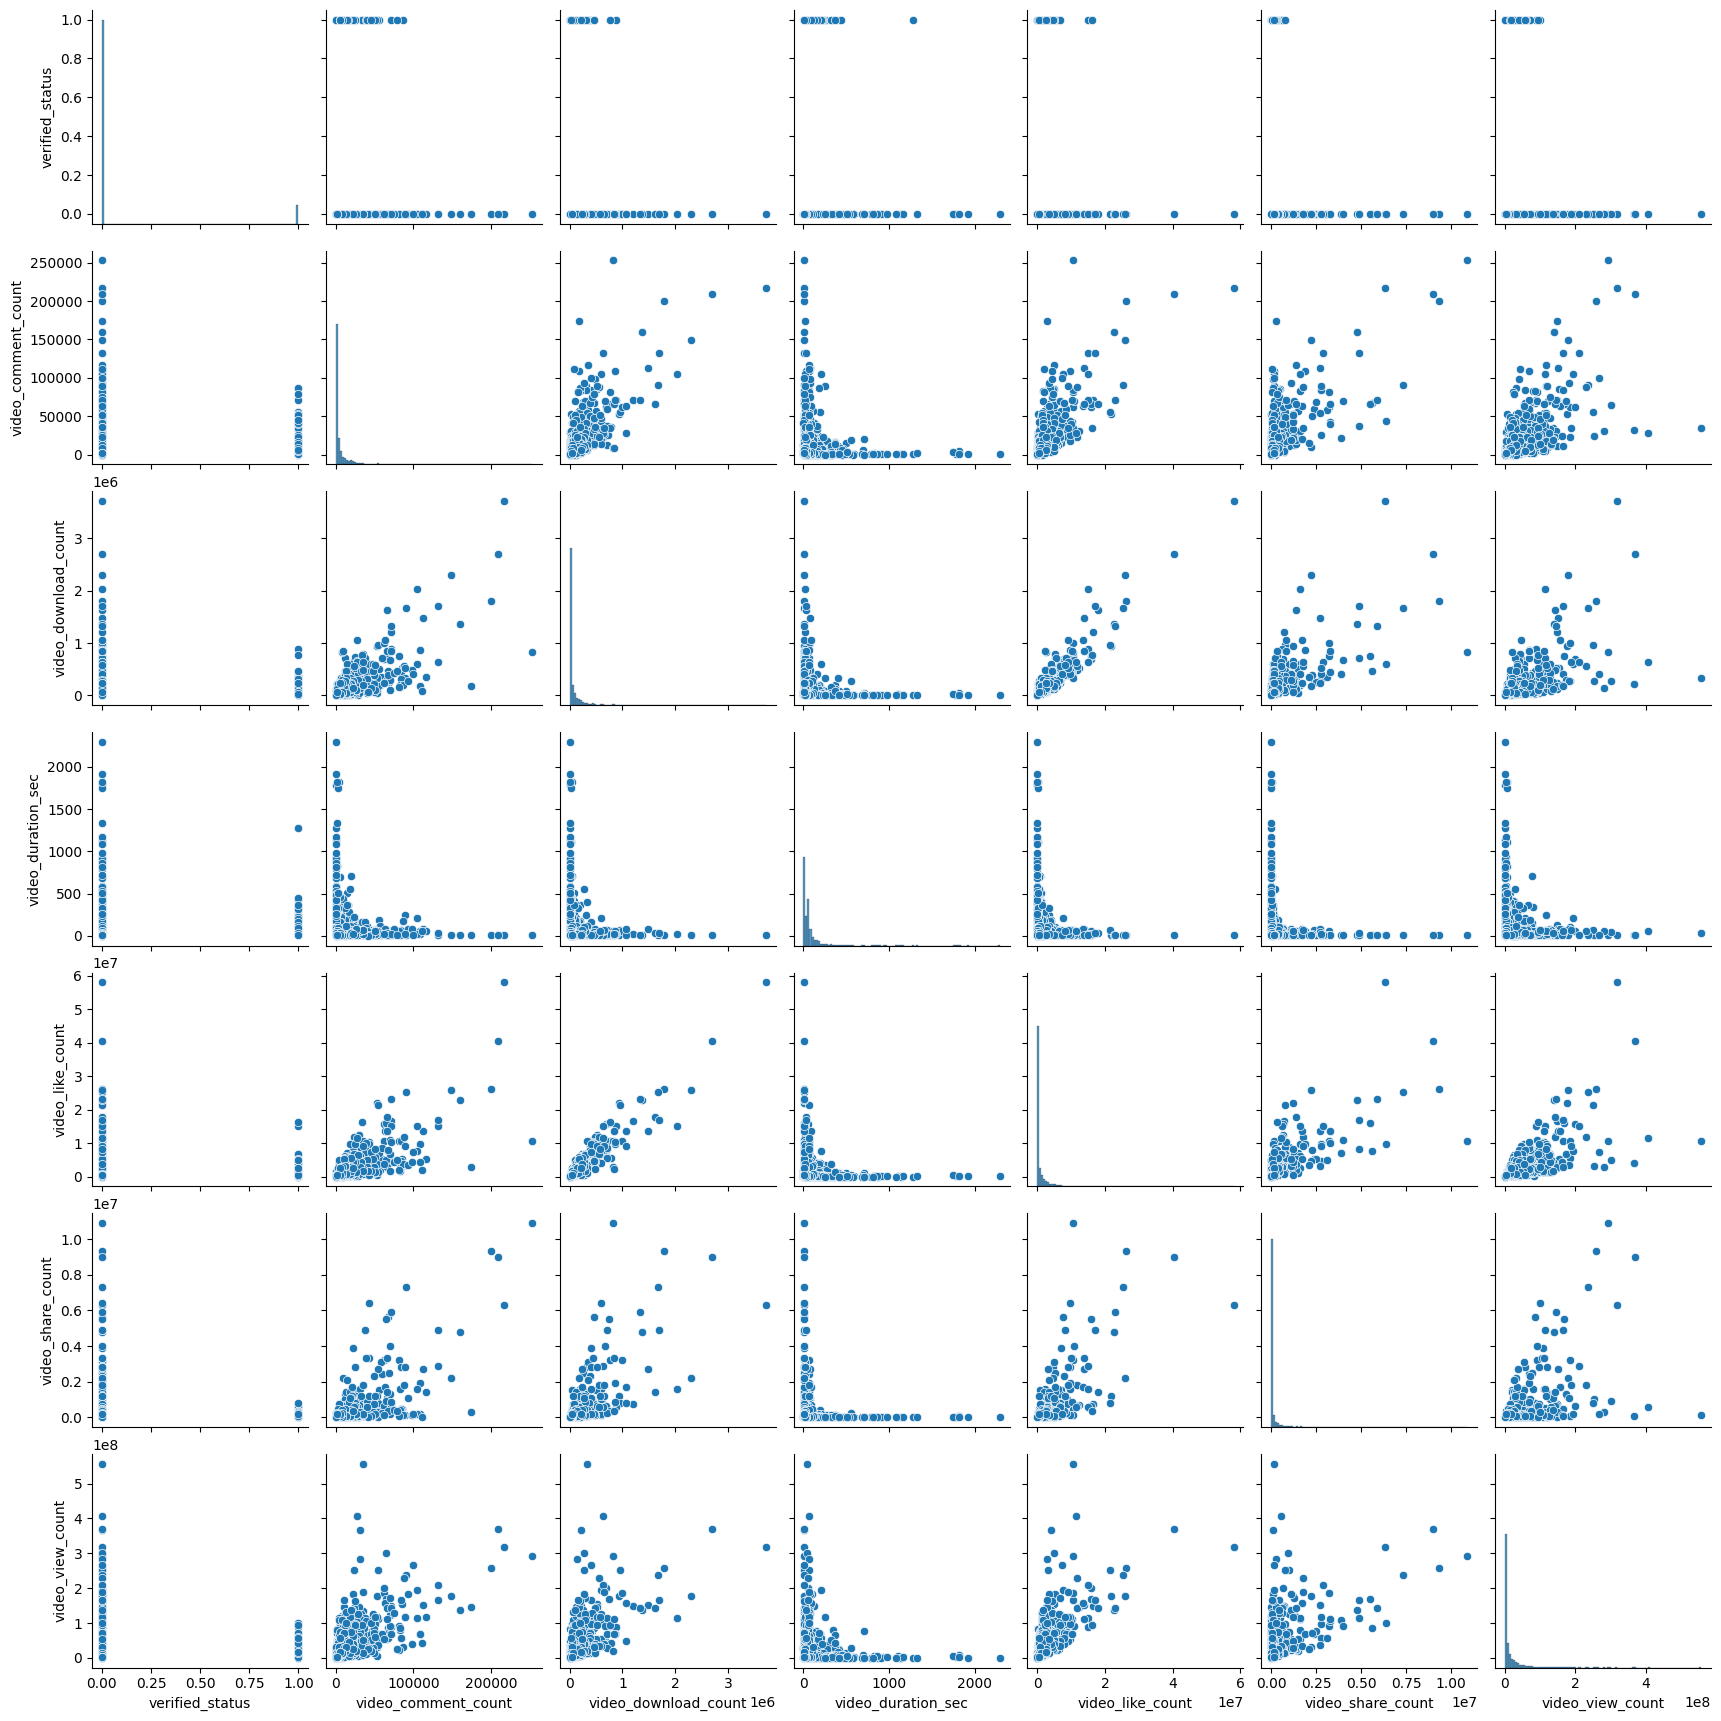

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(cleaned_df)

In [11]:
import numpy as np

In [12]:
cleaned_df.columns

Index(['author_id', 'author_username', 'verified_status', 'video_id',
       'video_comment_count', 'video_download_count', 'video_duration_sec',
       'video_like_count', 'video_share_count', 'video_view_count'],
      dtype='object')

<Axes: >

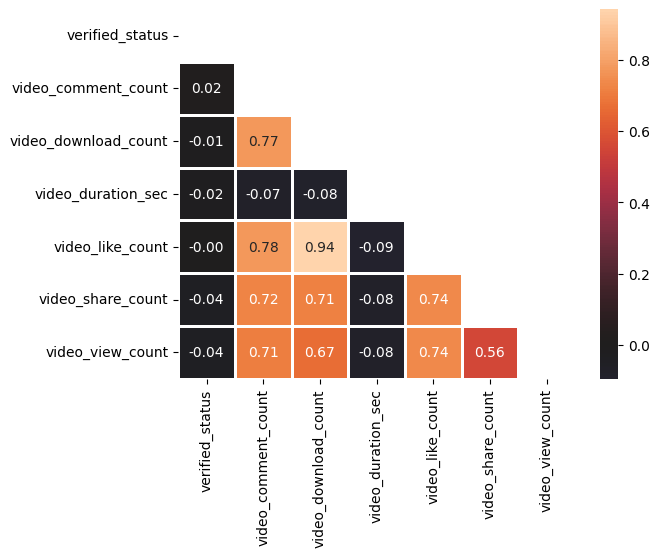

In [ ]:
corr = cleaned_df[["verified_status", "video_comment_count", "video_download_count", "video_duration_sec", "video_like_count", "video_share_count", "video_view_count"]].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, center=0, linewidths=1, annot=True, fmt=".2f")

In [14]:
cleaned_df.isna().sum()

author_id               0
author_username         0
verified_status         0
video_id                0
video_comment_count     0
video_download_count    0
video_duration_sec      0
video_like_count        0
video_share_count       0
video_view_count        0
dtype: int64

In [15]:
cleaned_df.to_pickle("cleaned.pkl")

## Engineer Features

In [ ]:
cleaned_df = pd.read_pickle("cleaned.pkl")

In [16]:
cleaned_df["author_ban_status"] = 2

In [18]:
df = cleaned_df[cleaned_df["video_view_count"] > 0]

In [20]:
df["engagement_rate"] = (
    df["video_like_count"] +
    df["video_share_count"] +
    df["video_download_count"] +
    df["video_comment_count"]
) / df["video_view_count"]

In [21]:
df["like_ratio"] = df["video_like_count"] / df["video_view_count"]
df["share_ratio"] = df["video_share_count"] / df["video_view_count"]
df["comment_ratio"] = df["video_comment_count"] / df["video_view_count"]

In [25]:
df.head()

,author_id,author_username,verified_status,video_id,video_comment_count,video_download_count,video_duration_sec,video_like_count,video_share_count,video_view_count,author_ban_status,engagement_rate,like_ratio,share_ratio,comment_ratio
0,6941201339713307650,deksorkrao_official,False,7523866066846551304,24600,145311,58,1100000,260700,17700000,2,0.086475,0.062147,0.014729,0.001390
1,6608161534445780993,mryang_english,False,7540993360086060295,565,6968,102,72600,8748,1100000,2,0.080801,0.066000,0.007953,0.000514
2,7064217605729862658,17._official,False,7531588956564016402,46900,414085,67,4300000,188800,77900000,2,0.063540,0.055199,0.002424,0.000602
3,7494496759856055312,cooking.cave,False,7537299029085113607,5952,33306,185,705600,15300,31200000,2,0.024364,0.022615,0.000490,0.000191
4,7300998376311538693,cryl8888,False,7530364484515269906,1459,3633,452,40600,3179,2000000,2,0.024435,0.020300,0.001589,0.000730


In [26]:
df.to_pickle("final.pkl")

## Upload Data to Supabase

In [1]:
import os

from dotenv import load_dotenv
from supabase import create_client

load_dotenv()

True

In [2]:
supabase = create_client(os.getenv("SUPABASE_URL"), os.getenv("SUPABASE_KEY"))

In [ ]:
df = pd.read_pickle("final.pkl")

In [27]:
df.head()

,author_id,author_username,verified_status,video_id,video_comment_count,video_download_count,video_duration_sec,video_like_count,video_share_count,video_view_count,author_ban_status,engagement_rate,like_ratio,share_ratio,comment_ratio
0,6941201339713307650,deksorkrao_official,False,7523866066846551304,24600,145311,58,1100000,260700,17700000,2,0.086475,0.062147,0.014729,0.001390
1,6608161534445780993,mryang_english,False,7540993360086060295,565,6968,102,72600,8748,1100000,2,0.080801,0.066000,0.007953,0.000514
2,7064217605729862658,17._official,False,7531588956564016402,46900,414085,67,4300000,188800,77900000,2,0.063540,0.055199,0.002424,0.000602
3,7494496759856055312,cooking.cave,False,7537299029085113607,5952,33306,185,705600,15300,31200000,2,0.024364,0.022615,0.000490,0.000191
4,7300998376311538693,cryl8888,False,7530364484515269906,1459,3633,452,40600,3179,2000000,2,0.024435,0.020300,0.001589,0.000730


In [28]:
# Convert count columns to integers to match Supabase schema
count_cols = [
    "video_view_count", "video_like_count", "video_share_count",
    "video_download_count", "video_comment_count"
]

for col in count_cols:
    df[col] = df[col].astype(int)

In [29]:
# Clean bad float values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [31]:
# Upload rows in chunks
chunk_size = 500
table_name = "scraped_dataset_cleaned"

for start in range(0, len(df), chunk_size):
    chunk = df.iloc[start:start+chunk_size]
    data = chunk.to_dict(orient="records")
    response = supabase.table(table_name).insert(data).execute()
    if response.data:
        print(f"✅ Inserted rows {start} to {start+len(data)}")
    else:
        print(f"❌ Failed to insert rows {start} to {start+len(data)} → Error: {response.error}")

✅ Inserted rows 0 to 500
✅ Inserted rows 500 to 1000
✅ Inserted rows 1000 to 1500
✅ Inserted rows 1500 to 2000
✅ Inserted rows 2000 to 2262
